# Simulations with PyHEADTAIL

## Imports

In [2]:
import PyHEADTAIL

PyHEADTAIL v1.12.4




In [3]:
from PyHEADTAIL.trackers.wrapper import LongWrapper

In [4]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib tk

import matplotlib.image as mpimg

from scipy.constants import c, e, m_p

from matplotlib import animation, rc
from IPython.display import HTML

In [5]:
from PyCERNmachines.CERNmachines import PS

## Defining several parameters of the accelerator

In [6]:
Ekin = 1.4e9
gamma = 1 + Ekin * e /(m_p*c**2)
beta = np.sqrt(1-gamma**-2)

Q_x = 6.23
Q_y = 6.24

machine = PS(n_segments=1, gamma=gamma, machine_configuration = 'LHCbeam_h7',
            longitudinal_focusing = 'non-linear', Q_x=Q_x, Q_y=Q_y)

Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_y = 6.24
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: gamma = 2.4921045053287254
Synchrotron init. From kwargs: Q_x = 6.23


In [7]:
1/machine.Q_s

739.9159648282383

In [8]:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

## Defining several parameters for the bunch/simulation

Defining the count of turns

In [9]:
n_turns = int((1/machine.Q_s) * 7.1)

Defining other parameters

In [10]:
n_macroparticles = 1000
intensity = 1.6e12
epsn_x = epsn_y = 2.5e-6
sigma_z = 185e-9/4*beta*c

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, epsn_x=epsn_x,
    epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562553m.


/afs/cern.ch/user/p/papostel/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169357977446
--> Emittance: 1.2136287277619604


Circumference of the PS

In [11]:
machine.circumference

628.3185307179587

In [12]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

In [13]:
rfsystems._elements.append(
    LongWrapper(machine.circumference))

Defining one particle outside the stable area

In [14]:
bunch.dp[0] = rfbucket.dp_max(rfbucket.z_ufp) * 1.1

Defining arrays to save the values of the simulation

In [15]:
x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
z_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
dp_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

## Simulation calculations

In [16]:
for i in range(n_turns):
    for m in machine.one_turn_map:
        x_rec[i, :] = bunch.x
        y_rec[i, :] = bunch.y
        z_rec[i, :] = bunch.z
        dp_rec [i, :] = bunch.dp
        m.track(bunch)

## Analysis of the simulation

Plotting the z-position

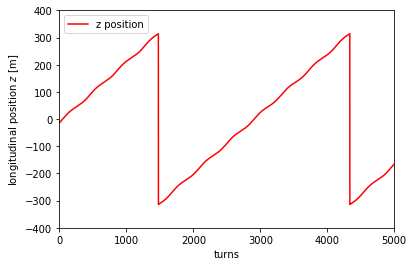

In [18]:
plt.plot(z_rec[:, 0], label='z position', color='red')
plt.legend(loc=2)
plt.xlim(0, 5000)
plt.ylim(-400, 400)
plt.xlabel('turns')
plt.ylabel('longitudinal position $z$ [m]')
plt.show()

Plotting the momentum deviation $\delta$ for one of the other particles

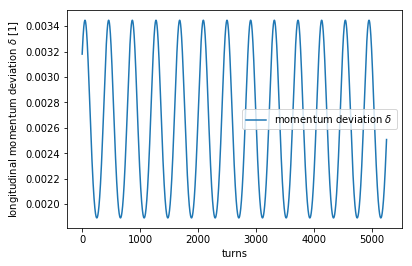

In [20]:
plt.plot(dp_rec[:, 0], label='momentum deviation $\delta$')
plt.legend()
# plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('longitudinal momentum deviation $\delta$ [1]')
plt.show()

## Longitudinal Motion:

### The motion of one particle outside the stable area

Animating a video of all seven buckets, so you can see the particle outside the stable area moving through all seven buckets

In [21]:
!mkdir Video_Longitudinal_Motion_Seven_Buckets

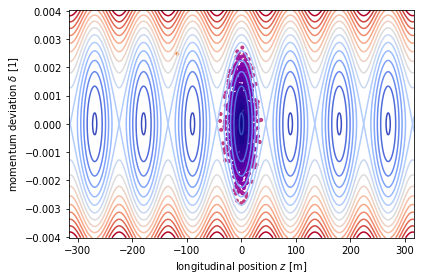

In [24]:
!rm Video_Longitudinal_Motion_Seven_Buckets/*

zz = np.linspace(rfbucket.z_left - 3 * np.diff(rfbucket.interval), 
                 rfbucket.z_right + 3 * np.diff(rfbucket.interval), 
                 num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.4, dp_max*1.4, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

def animate (i):
    plt.cla()
    z = z_rec[i, :]
    dp = dp_rec[i, :]
    
    plt.scatter(z, dp, marker='.', c=rfbucket.hamiltonian(z, dp), 
                cmap=plt.get_cmap('plasma'), vmax=np.max(np.abs(rfbucket.hamiltonian(z, dp))) * 1)
    
    plt.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))

    plt.ylim(-dp_max * 1.4, dp_max * 1.4)
    
    plt.xlabel('longitudinal position $z$ [m]')
    plt.ylabel('momentum deviation $\delta$ [1]')
    
    plt.tight_layout()
    
    x = z_rec[i, :]
    y = dp_rec[i, :]
    
    plt.savefig("Video_Longitudinal_Motion_Seven_Buckets/src{:05d}.png".format(i), dpi=200, bbox_inches='tight')

for i in range(0, len(z_rec), 10):
    animate(i)

In [25]:
!cd Video_Longitudinal_Motion_Seven_Buckets; ffmpeg -y -pattern_type glob -i "*.png" -c:v msmpeg4v2 -q:v 2 -pix_fmt yuv420p Seven_buckets.wmv

ffmpeg version N-90661-g52623bc Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-18)
  configuration: --prefix=/afs/cern.ch/user/p/papostel/lib/
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 14.100 /  7. 14.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
Input #0, image2, from '*.png':
  Duration: 00:00:21.04, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1166x771 [SAR 7874:7874 DAR 1166:771], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> msmpeg4v2 (native))
Press [q] to stop, [?] for help
Output #0, asf, to 'Seven_buckets.wmv':
  Metadata:
    WM/EncodingSettings: Lavf58.11.101
    Stream #0:0: Video: msmpeg4v2 (MP42 / 0x3234504D), yuv420p, 1166x771 [SAR 1:1 DAR 1166:771], q=2-31, 200 kb/s, 25 fps, 1

See also the orginial code:

https://github.com/PyCOMPLETE/PyHEADTAIL-playground/blob/master/index.ipynb

## The End